# SAIL Radiosonde Data Example
### Created by Daniel Hogan - University of Washington
-----------------------------------------
This notebook is designed to investigate recent 2022/2023 winter radiosonde data from SAIL launched from Gothic, CO over a variety of conditions

The `act` package is required for this notebook to download and easily visualize the data. Check out the documentation [here](https://arm-doe.github.io/ACT/index.html).

In [3]:
# Import packages to be used
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import act
from soslib import funcs


# Pull in Data
-------------------------------------

### Use personal access token to pull data
- data is stored temporarily, so it is not saved locally

In [21]:
# Personal access necessary for downloading from the ARM portal, need an account to due so
username = 'dlhogan@uw.edu'
token = '7f1c805e6ae94c21'
radiosonde ='gucsondewnpnM1.b1'
start = '2022-10-06'
end = '2022-10-07' 

In [22]:
# Download SAIL sonde data
sonde_ds = funcs.get_sail_data(username, token, radiosonde, start, end)

[DOWNLOADING] gucsondewnpnM1.b1.20221006.113100.cdf
                             


The variable(s) qc_pres,qc_tdry,qc_dp,qc_wspd,qc_deg,qc_rh,qc_u_wind,qc_v_wind,qc_asc have integer data type. Consider setting data type to float 'F64' or 'F32' using set_precision.


[DOWNLOADING] gucsondewnpnM1.b1.20221006.232900.cdf
                             


The variable(s) qc_pres,qc_tdry,qc_dp,qc_wspd,qc_deg,qc_rh,qc_u_wind,qc_v_wind,qc_asc have integer data type. Consider setting data type to float 'F64' or 'F32' using set_precision.


### Add potenetial temperature here for a potential temperature profile

In [23]:
# Don't need to worry about this
kappa = 0.286
sonde_ds = sonde_ds.assign(potential_T = (273.15 + sonde_ds.where(sonde_ds['qc_tdry'] == 0)['tdry']) * (1000 / sonde_ds.where(sonde_ds['qc_tdry'] == 0)['pres'])**kappa - 273.15)
sonde_ds['potential_T'].attrs = {'units':'degC'}

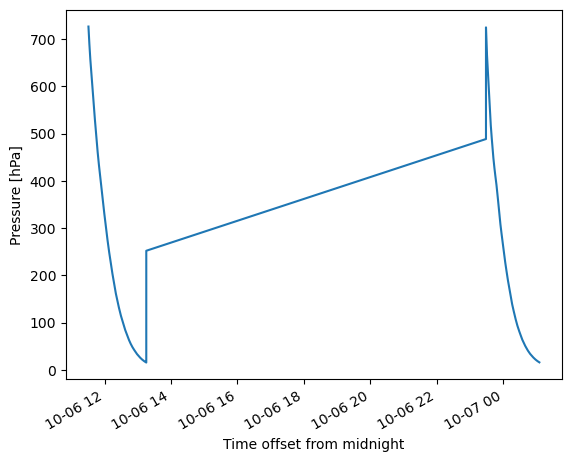

In [42]:
sonde_ds.pres.plot()

# Plotting 
--------------------------------

### Using ACT plotting functionality, we will plot the radiosonde profiles from these days

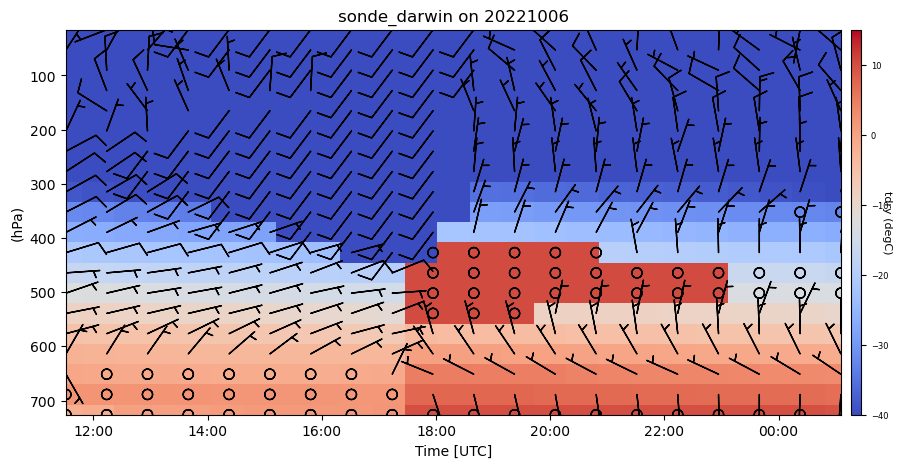

In [39]:
# Don't need to worry about this
BarbDisplay = act.plotting.TimeSeriesDisplay({'sonde_darwin': sonde_ds}, figsize=(10, 5))
BarbDisplay.plot_time_height_xsection_from_1d_data(
    'tdry', 'pres', cmap='coolwarm', vmin=-40, vmax=15, num_time_periods=25
)
BarbDisplay.plot_barbs_from_spd_dir('wspd', 'deg', 'pres', num_barbs_x=20)
plt.show()

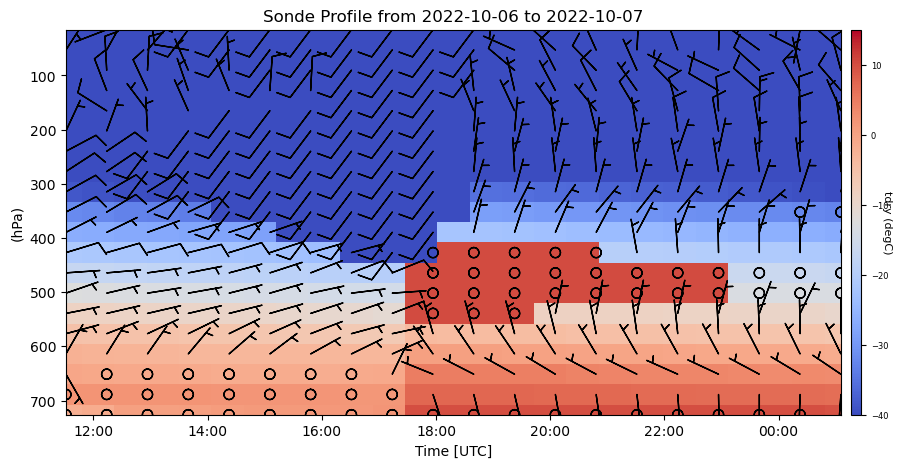

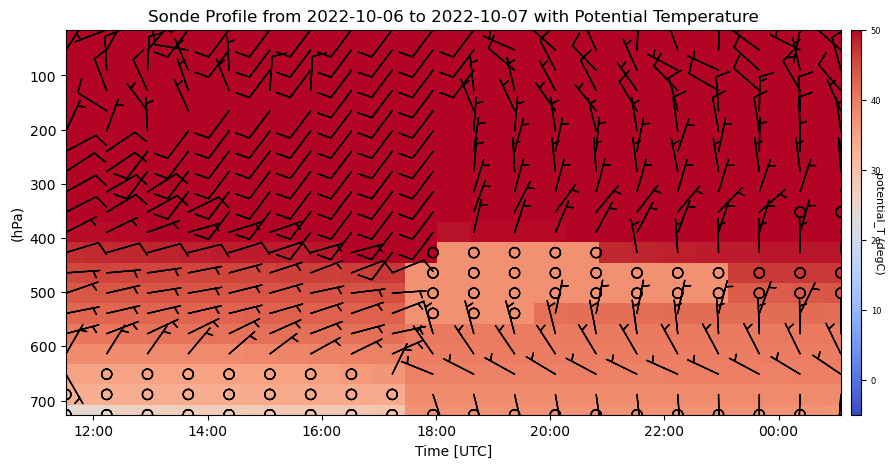

In [41]:
# Don't need to worry about this
BarbDisplay = act.plotting.TimeSeriesDisplay({'sonde_darwin': sonde_ds}, figsize=(10, 5))
BarbDisplay.plot_time_height_xsection_from_1d_data(
    'tdry', 'pres', cmap='coolwarm', vmin=-40, vmax=15, num_time_periods=25
)
BarbDisplay.plot_barbs_from_spd_dir('wspd', 'deg', 'pres', num_barbs_x=20,
                                    set_title=f'Sonde Profile from {start} to {end}')
plt.show()
# Don't need to worry about this
BarbDisplay = act.plotting.TimeSeriesDisplay({'sonde_darwin': sonde_ds}, figsize=(10, 5))
BarbDisplay.plot_time_height_xsection_from_1d_data(
    'potential_T', 'pres', cmap='coolwarm', vmin=-5, vmax=50, num_time_periods=25
)
BarbDisplay.plot_barbs_from_spd_dir('wspd', 'deg', 'pres', num_barbs_x=20,
                                    set_title=f'Sonde Profile from {start} to {end} with Potential Temperature')
plt.show()

<xarray.DataArray 'lifted_index' ()>
array(8.98051843)
Attributes:
    units:      kelvin
    long_name:  Lifted index


InvalidSoundingError: 
        Pressure increases between at least two points in your sounding.
        Using scipy.signal.medfilt may fix this.

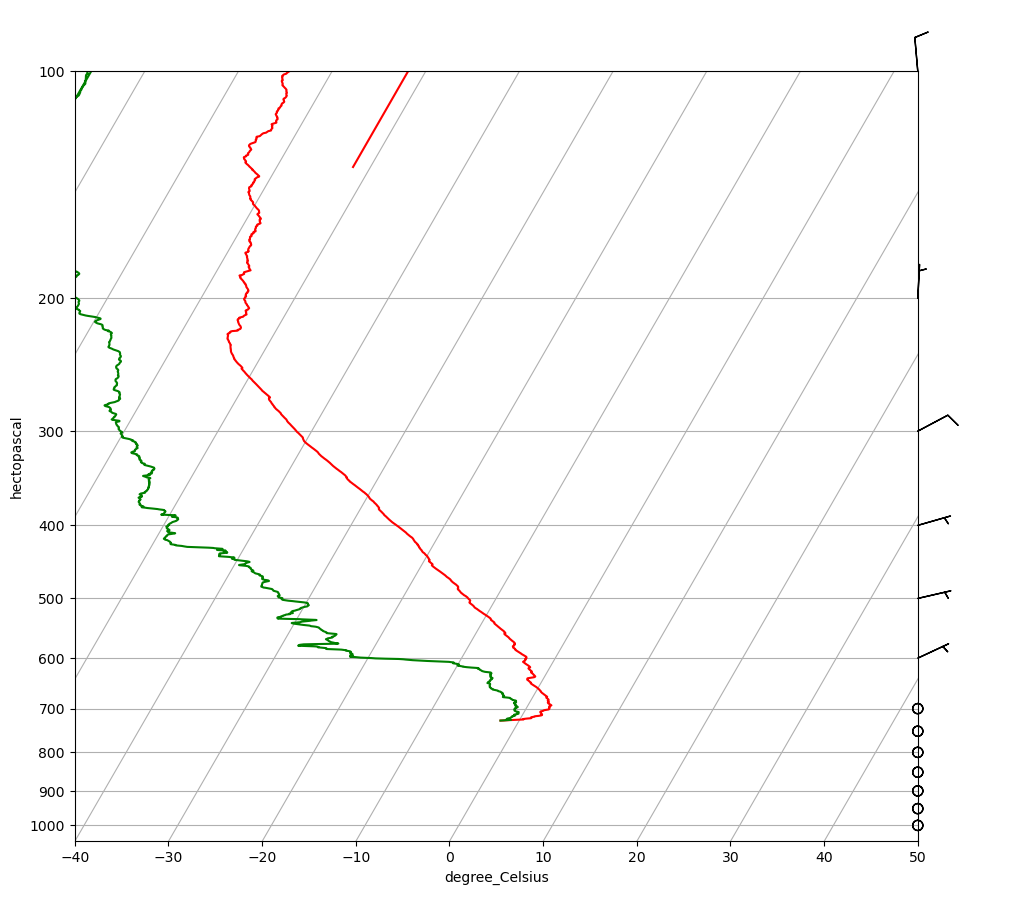

In [45]:
# Calculate stability indeces 
sonde_ds_subset = act.retrievals.calculate_stability_indicies(sonde_ds.sel(time=slice('2022-10-06 10','2022-10-06 14')), temp_name='tdry', td_name='dp', p_name='pres', rh_name='rh')
print(sonde_ds_subset['lifted_index'])

# Set up plot
skewt = act.plotting.SkewTDisplay(sonde_ds_subset, figsize=(15, 10))

# Add data
skewt.plot_from_u_and_v('u_wind', 'v_wind', 'pres', 'tdry', 'dp', shade_cin=False)
sonde_ds_subset.close()
plt.show()


/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


<xarray.DataArray 'lifted_index' ()>
array(7.61182246)
Attributes:
    units:      kelvin
    long_name:  Lifted index


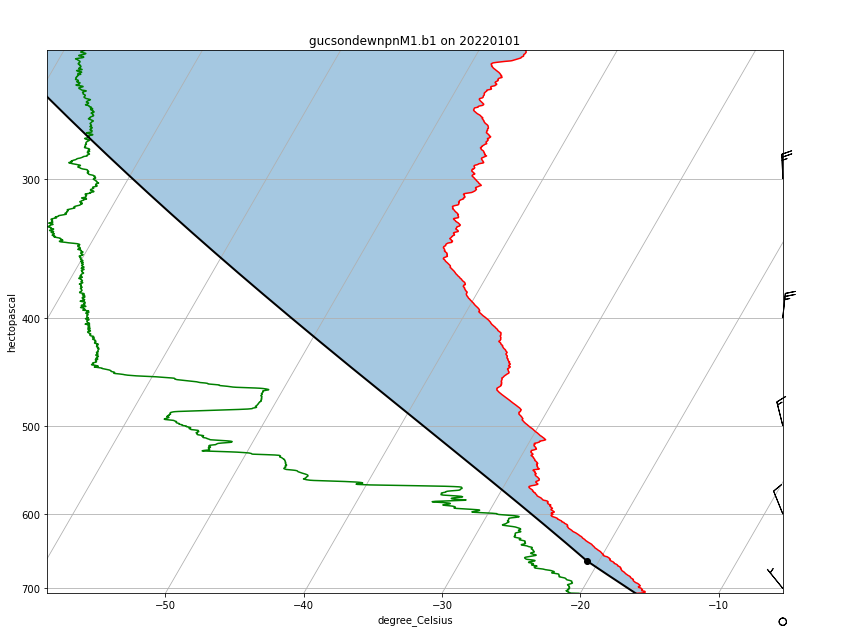

In [60]:
# Calculate stability indeces 
sonde_ds_subset = act.retrievals.calculate_stability_indicies(sonde_ds.sel(time=slice('2022-01-01 15', '2022-01-01 23')), temp_name='tdry', td_name='dp', p_name='pres', rh_name='rh')
print(sonde_ds_subset['lifted_index'])

# Set up plot
skewt = act.plotting.SkewTDisplay(sonde_ds_subset, figsize=(15, 10))

# Add data
skewt.plot_from_u_and_v('u_wind', 'v_wind', 'pres', 'tdry', 'dp', shade_cin=True)
sonde_ds_subset.close()
plt.show()

In [58]:
def plot_sonde(date,variable, limits, title):
    # Apply date filter
    sonde_temp_profile = sonde_ds.sel(time=slice(f'{date} 09',f'{date} 15')).resample(time='min').mean()
        
    # Plot data
    fig, axs = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)
    axs[0].plot(sonde_temp_profile[variable],sonde_temp_profile['alt'])
    axs[0].set_xlim(limits[0],limits[1])
    axs[0].set_ylim(3000,10000)
    axs[0].set_xlabel('Relative Humidity (%)');
    axs[0].set_ylabel('Altitude (m)');
    axs[0].set_title(f'{variable.upper()} with Altitude');

    axs[1].plot(sonde_temp_profile[variable],sonde_temp_profile['pres'])
    axs[1].set_xlim(limits[0],limits[1])
    axs[1].set_ylim(725,350)
    axs[1].set_xlabel('Relative Humidity (%)');
    axs[1].set_ylabel('Pressure (mbar)');
    axs[1].set_title(f'{variable.upper()} with Pressure');

    fig.suptitle(f'{title} on {date}')
    return

In [8]:
sonde_ds_abl = sonde_ds.where(sonde_ds.alt<4000)

In [9]:
from datetime import datetime
import warnings
dates = np.unique(pd.to_datetime(sonde_ds_abl.time).date)
make_df=False

In [10]:
if make_df is True:
    abl_heights = []
    inversion_bool = []

    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for i,date in enumerate(dates):
        
        # set start and end dates with times
        start = date.strftime("%Y-%m-%d")+" 06"
        end = date.strftime("%Y-%m-%d")+" 17"
        print(f'Starting {start}')

        # slice for daily radiosonde
        daily_radiosonde = sonde_ds_abl.sel(time=slice(start, end))
        try:
            # separate into 10 meter averages
            alt_groups = daily_radiosonde.groupby(daily_radiosonde.alt // 10).mean()
            # calculate abl height
            abl_height = 10 * (alt_groups.tdry.diff(dim='alt')<0).idxmax().compute().values - daily_radiosonde.alt.min()
            abl_heights.append(abl_height)

            # if abl height is larger than 10 meters, inversion exists
            if abl_height > 10:
                inversion_bool.append(True)
            else: inversion_bool.append(False)
        except:
            pass
else:
    hgts_day_df = pd.read_csv(os.path.join(outpath, 'inversion_heights_day.csv'))

In [ ]:
if make_df is True:
    hgts_day = [abl_heights[i].compute().values for i in range(len(abl_heights))]
    hgts_day_df = pd.DataFrame([hgts_day,inversion_bool]).T
    hgts_day_df = hgts_day_df.rename(columns={0:'heights',1:'inversion_bool'})
    hgts_day_df.to_csv(os.path.join(outpath,'inversion_heights_day.csv'))

In [61]:
make_df=True
if make_df is True:
    dates = np.unique(pd.to_datetime(sonde_ds_abl.time).date)
    abl_heights_night = []
    inversion_bool_night = []
    sonde_date = []
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for i,date in enumerate(dates):
        
        # set start and end dates with times
        start = date.strftime("%Y-%m-%d")+" 18"
        end = dates[i+1].strftime("%Y-%m-%d")+" 05"
        print(f'Starting {start}')

        # slice for daily radiosonde
        daily_radiosonde = sonde_ds_abl.sel(time=slice(start, end))
        try:
            # separate into 10 meter averages
            alt_groups = daily_radiosonde.groupby(daily_radiosonde.alt // 10).mean()
            sonde_date.append(date)
            # # calculate abl height
            # abl_height_night = 10 * (alt_groups.tdry.diff(dim='alt')<0).idxmax().compute().values - daily_radiosonde.alt.min()
            # abl_heights_night.append(abl_height_night)

            # if abl height is larger than 10 meters, inversion exists
            # if abl_height_night > 10:
            #     inversion_bool_night.append(True)
            # else: inversion_bool_night.append(False)
        except:
            pass
    else:
        hgts_night_df = pd.read_csv(os.path.join(outpath, 'inversion_heights_night.csv'))

Starting 2021-12-20 18
Starting 2021-12-21 18
Starting 2021-12-22 18
Starting 2021-12-23 18
Starting 2021-12-24 18
Starting 2021-12-25 18
Starting 2021-12-26 18
Starting 2021-12-27 18
Starting 2021-12-28 18
Starting 2021-12-29 18
Starting 2021-12-30 18
Starting 2021-12-31 18
Starting 2022-01-01 18
Starting 2022-01-02 18
Starting 2022-01-03 18
Starting 2022-01-04 18
Starting 2022-01-05 18
Starting 2022-01-06 18
Starting 2022-01-07 18
Starting 2022-01-08 18
Starting 2022-01-09 18
Starting 2022-01-10 18
Starting 2022-01-11 18
Starting 2022-01-12 18
Starting 2022-01-13 18
Starting 2022-01-14 18
Starting 2022-01-15 18
Starting 2022-01-16 18
Starting 2022-01-17 18
Starting 2022-01-18 18
Starting 2022-01-19 18
Starting 2022-01-20 18
Starting 2022-01-21 18
Starting 2022-01-22 18
Starting 2022-01-23 18
Starting 2022-01-24 18
Starting 2022-01-25 18
Starting 2022-01-26 18
Starting 2022-01-27 18
Starting 2022-01-28 18
Starting 2022-01-29 18
Starting 2022-01-30 18
Starting 2022-01-31 18
Starting 20

IndexError: index 73 is out of bounds for axis 0 with size 73

In [165]:
if make_df is True:
    hgts_night = [abl_heights_night[i].compute().values for i in range(len(abl_heights_night))]
    hgts_night_df = pd.DataFrame([hgts_night,inversion_bool_night]).T
    hgts_night_df = hgts_night_df.rename(columns={0:'heights',1:'inversion_bool'})
    hgts_night_df.to_csv(os.path.join(outpath,'inversion_heights_night.csv'))

0.835820895522388

Text(0.5, 1.0, 'SAIL Radiosonde Profiles with Near Surface Inversion\nDecember 2021 - March 2022')

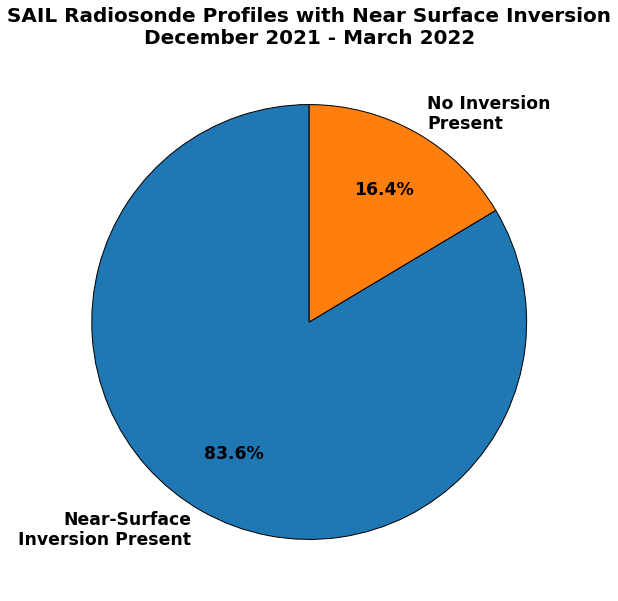

In [52]:
fig, ax = plt.subplots(figsize=(12,10))
fig.set_facecolor('white')

title = 'SAIL Radiosonde Profiles with Near Surface Inversion\nDecember 2021 - March 2022'
labels = ['Near-Surface\nInversion Present','No Inversion\nPresent']

inversion_percent = 100*hgts_day_df[hgts_day_df['inversion_bool']==True]['inversion_bool'].sum()/len(hgts_day_df)


unstable = 100 - inversion_percent
sizes = [inversion_percent, unstable]
pie_plot = ax.pie(sizes,autopct='%1.1f%%', wedgeprops={'linewidth':1, 'edgecolor':'k'},labels=labels, 
                      startangle=90, pctdistance=0.7,radius=1, labeldistance=1.1, textprops={'color':'black','size': 'xx-large','fontweight':'bold'})
ax.set_title(f'{title}', size=20, fontweight='bold')

In [54]:
len(hgts_day_df['inversion_bool'])

67

In [58]:
hgts_day_df.loc[5:20]

,Unnamed: 0,heights,inversion_bool
5,5,11.600098,True
6,6,11.600098,True
7,7,11.600098,True
8,8,11.600098,True
9,9,11.600098,True
10,10,71.600100,True
11,11,441.600100,True
12,12,11.600098,True
13,13,11.600098,True
14,14,71.600100,True


In [56]:
31+31+28


90